# Logistic Regression for Food and Non-Food Classifier
By: Reza Yogaswara
____

In [25]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dropout, Input
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from keras.callbacks import TensorBoard
from keras.models import Model
from keras.utils import np_utils
import itertools
import matplotlib.pyplot as plt
import livelossplot
%matplotlib inline
import tensorflow as tf
plot_losses = livelossplot.PlotLossesKeras()

In [2]:
PATH = './Food-5K/'

train_path = '%straining/' %PATH
valid_path = '%svalidation/' %PATH
test_path = '%sevaluation/' %PATH

classes = ('food', 'non-food')

print (train_path)

./Food-5K/training/


In [15]:
batch_size = 16
epochs = 20
nb_train_samples = 3001
nb_validation_samples = 1000

train_batches = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True).flow_from_directory(train_path, target_size=(224,224),
        batch_size=32, class_mode='binary')
valid_batches = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(valid_path, target_size=(224,224), 
        batch_size=batch_size, class_mode='binary')
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), 
        batch_size=batch_size, class_mode='binary')

print(type(train_batches[0]))

x_train, y_train = train_batches[0]
x_test, y_test = valid_batches[0]

print('x_train.shape: ' + str(x_train.shape))
print('y_train.shape: ' + str(y_train.shape))
print('y_train.shape: ' + str(y_train.reshape(y_train.shape + (1,)).shape))

print('x_test.shape: ' + str(x_test.shape))
print('y_test.shape: ' + str(y_test.shape))
print('y_test.shape: ' + str(y_test.reshape(y_test.shape + (1,)).shape))

X_train_flatten = x_train.reshape(x_train.shape[0], -1).T
X_test_flatten = x_test.reshape(x_test.shape[0], -1).T

y_train_flatten = y_train.T
y_test_flatten = y_test.T

print('X_train_flatten.shape: ' + str(X_train_flatten.T.shape))
print('y_train_flatten.shape: ' + str(y_train_flatten.shape))
#print('y_train_flatten.shape: ' + str(np.squeeze(y_train_flatten, axis=(2,)).shape))

print('X_test_flatten.shape: ' + str(X_test_flatten.T.shape))
print('y_test_flatten.shape: ' + str(y_test_flatten.shape))
#print('y_test_flatten.shape: ' + str(np.squeeze(y_test_flatten, axis=(2,)).shape))

train_set_x = X_train_flatten/255.
test_set_x = X_test_flatten/255.

print('len(train_set_x): ' + str(train_set_x.shape))
print('len(test_set_x): ' + str(test_set_x.shape))

print(y_train.shape)

'''
MNIST 28x28x1

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_Train = np_utils.to_categorical(y_train, nb_classes)
Y_Test = np_utils.to_categorical(y_test, nb_classes)
'''

Found 3001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
<class 'tuple'>
x_train.shape: (32, 224, 224, 3)
y_train.shape: (32,)
y_train.shape: (32, 1)
x_test.shape: (16, 224, 224, 3)
y_test.shape: (16,)
y_test.shape: (16, 1)
X_train_flatten.shape: (32, 150528)
y_train_flatten.shape: (32,)
X_test_flatten.shape: (16, 150528)
y_test_flatten.shape: (16,)
len(train_set_x): (150528, 32)
len(test_set_x): (150528, 16)
(32,)


"\nMNIST 28x28x1\n\nX_train = X_train.reshape(60000, 784)\nX_test = X_test.reshape(10000, 784)\nX_train = X_train.astype('float32')\nX_test = X_test.astype('float32')\nX_train /= 255\nX_test /= 255\nY_Train = np_utils.to_categorical(y_train, nb_classes)\nY_Test = np_utils.to_categorical(y_test, nb_classes)\n"

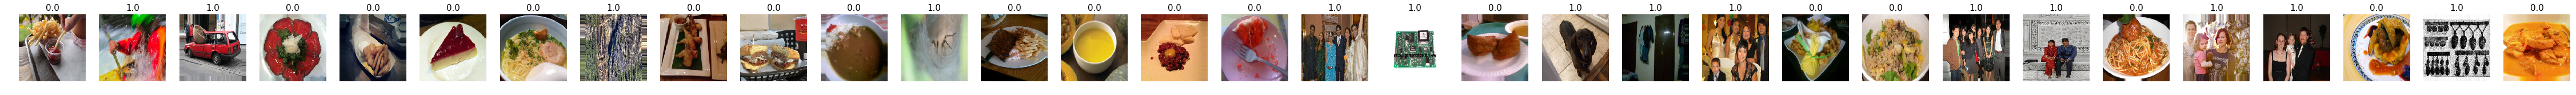

In [16]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(80,60), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        #print(ims[0])
        #ims = np.array(ims).astype(np.uint8)
        #print(ims)
        
        if (ims.shape[-1] != 3):
            ims = ims.transpose((1,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=15)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

# Build and train Logistic Regression

In [22]:
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()
#model.compile(Adadelta(lr=.0001), loss='binary_crossentropy', metrics=['accuracy', 'mean_squared_error'])
model.compile(optimizer=Adam(lr=.0001), loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 150529    
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Use TensorBoard
callbacks = TensorBoard(log_dir='./Graph')
history = model.fit_generator(train_batches, steps_per_epoch=32, #steps_per_epoch=nb_train_samples, 
                         callbacks=[callbacks],
                              validation_steps = 16,
                    validation_data=train_batches, epochs=epochs, verbose=1)

Epoch 1/20
32/32 [==============================] - 42s 1s/step - loss: 0.4997 - acc: 0.7656 - val_loss: 0.4623 - val_acc: 0.7812
Epoch 2/20
32/32 [==============================] - 36s 1s/step - loss: 0.5514 - acc: 0.7396 - val_loss: 0.5238 - val_acc: 0.7676
Epoch 3/20
32/32 [==============================] - 33s 1s/step - loss: 0.5815 - acc: 0.7393 - val_loss: 0.5217 - val_acc: 0.7793
Epoch 4/20
32/32 [==============================] - 37s 1s/step - loss: 0.4880 - acc: 0.7894 - val_loss: 0.4501 - val_acc: 0.8223
Epoch 5/20
32/32 [==============================] - 33s 1s/step - loss: 0.4629 - acc: 0.7861 - val_loss: 0.4410 - val_acc: 0.8281
Epoch 6/20
32/32 [==============================] - 33s 1s/step - loss: 0.5383 - acc: 0.7539 - val_loss: 0.4970 - val_acc: 0.7832
Epoch 7/20
32/32 [==============================] - 27s 844ms/step - loss: 0.4873 - acc: 0.7865 - val_loss: 0.5891 - val_acc: 0.7129
Epoch 8/20
32/32 [==============================] - 28s 879ms/step - loss: 0.4634 - acc

In [20]:
# Evaluate
x_test, y_test = valid_batches[0]
evaluation = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

16/16 [==============================] - 0s 594us/step
Summary: Loss over the test dataset: 1.95, Accuracy: 0.50


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


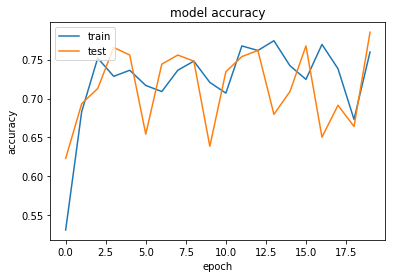

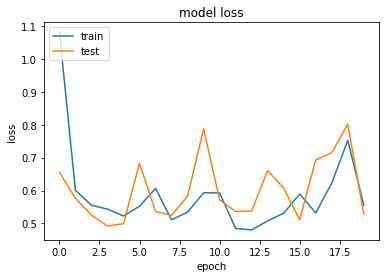

In [8]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()